<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Laboratorio: Construcción Modelo de Clasificación y Evaluación de Métricas

Tras realizar el preprocesamiento de los datos y dejarlos listos para construir modelos, ha llegado el momento de dar el siguiente paso: desarrollar tu **primer modelo de clasificación**.

El objetivo de este laboratorio es implementar un modelo de clasificación inicial utilizando **Regresión Logística (Logistic Regression)**. Este modelo te permitirá obtener las primeras predicciones para identificar transacciones normales y anómalas, así como evaluar su desempeño utilizando métricas estándar.

Además, deberás evaluar si el modelo está en riesgo de **overfitting**, asegurando que nuestras predicciones sean consistentes tanto en los datos de entrenamiento como en los de prueba.






In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

# Importamos nuestras funciones
# -----------------------------------------------------------------------
from src import  soporte_ajuste_logistica as sal

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Para realizar la clasificación y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import pickle
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from itertools import product , combinations
from sklearn.experimental import enable_iterative_imputer  # Necesario para habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from src.soporte_metricas import (
    obtener_metricas_logistica
)

In [2]:
df = pd.read_csv("datos/03_financial_data_minmaxscaler.csv")

In [3]:
df.head()

,transaction_id,customer_id,merchant_id,amount,purchase_category,customer_age,is_fraudulent,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9,transaction_description_Purchase at Merchant-2001,transaction_description_Purchase at Merchant-2002,transaction_description_Purchase at Merchant-2003,transaction_description_Purchase at Merchant-2004,transaction_description_Purchase at Merchant-2005,transaction_description_Purchase at Merchant-2006,transaction_description_Purchase at Merchant-2007,transaction_description_Purchase at Merchant-2008,transaction_description_Purchase at Merchant-2009,transaction_description_Purchase at Merchant-2010,transaction_description_Purchase at Merchant-2011,transaction_description_Purchase at Merchant-2012,transaction_description_Purchase at Merchant-2013,transaction_description_Purchase at Merchant-2014,transaction_description_Purchase at Merchant-2015,transaction_description_Purchase at Merchant-2016,transaction_description_Purchase at Merchant-2017,transaction_description_Purchase at Merchant-2018,transaction_description_Purchase at Merchant-2019,transaction_description_Purchase at Merchant-2020,transaction_description_Purchase at Merchant-2021,transaction_description_Purchase at Merchant-2022,transaction_description_Purchase at Merchant-2023,transaction_description_Purchase at Merchant-2024,transaction_description_Purchase at Merchant-2025,transaction_description_Purchase at Merchant-2026,transaction_description_Purchase at Merchant-2027,transaction_description_Purchase at Merchant-2028,transaction_description_Purchase at Merchant-2029,transaction_description_Purchase at Merchant-2030,transaction_description_Purchase at Merchant-2031,transaction_description_Purchase at Merchant-2032,transaction_description_Purchase at Merchant-2033,transaction_description_Purchase at Merchant-2034,transaction_description_Purchase at Merchant-2035,transaction_description_Purchase at Merchant-2036,transaction_description_Purchase at Merchant-2037,transaction_description_Purchase at Merchant-2038,transaction_description_Purchase at Merchant-2039,transaction_description_Purchase at Merchant-2040,transaction_description_Purchase at Merchant-2041,transaction_description_Purchase at Merchant-2042,transaction_description_Purchase at Merchant-2043,transaction_description_Purchase at Merchant-2044,transaction_description_Purchase at Merchant-2045,transaction_description_Purchase at Merchant-2046,transaction_description_Purchase at Merchant-2047,transaction_description_Purchase at Merchant-2048,transaction_description_Purchase at Merchant-2049,transaction_description_Purchase at Merchant-2050,transaction_description_Purchase at Merchant-2051,transaction_description_Purchase at Merchant-2052,transaction_description_Purchase at Merchant-2053,transaction_description_Purchase at Merchant-2054,transaction_description_Purchase at Merchant-2055,transaction_description_Purchase at Merchant-2056,transaction_description_Purchase at Merchant-2057,transaction_description_Purchase at Merchant-2058,transaction_description_Purchase at Merchant-2059,transaction_description_Purchase at

# INFO VR
- 0: Normal (No)
- 1: Fraudulenta (Si)

## Objetivo del Laboratorio

1. Entrenar un modelo de **Regresión Logística** para predecir si una transacción es "Normal" o "Anómala".

### Manualmente

#### Separar X e Y
```py
    X = df.drop(columns="is_fraudulent")
    y = df["is_fraudulent"]

    X_train, X_test, y_train, y_test  = train_test_split(X,y, train_size=0.8,random_state=42, shuffle=True)
```
#### Definir, Instanciar y Ajustar Modelo
```py
    # Definir Parámetros
    params_logistic = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 200, 500]
    }

    # Crear una instancia de LogisticRegression con parámetros personalizados
    modelo_logistica = LogisticRegression()

    # Ajuste del modelo
    grid_search_logistica = GridSearchCV(estimator=modelo_logistica, 
                                    param_grid=params_logistic, 
                                    cv=5, 
                                    scoring='accuracy')

    grid_search_logistica.fit(X_train,y_train)
    modelo_final_logistica = grid_search_logistica.best_estimator_

    # Ajustar el modelo con los datos de entrenamiento
    modelo_final_logistica.fit(X_train, y_train)

    # Hacer las predicciones para los datos
    y_predict_train = modelo_final_logistica.predict(X_train)
    y_predict_test = modelo_final_logistica.predict(X_test)
```
#### Obtener Probabilidad de cada clase
Usamos **predict_proba** que nos devuelve la probabilidad
```py 
    # Obtener Probabilidades predichas
    y_prob_train = modelo_final_logistica.predict_proba(X_train)
    y_prob_test = modelo_final_logistica.predict_proba(X_test)

    # Para hacer AUC lo configuramos así (es un array bidimensional)
    prob_train = y_prob_train[:, 1]
    prob_test = y_prob_test[:, 1]
```
### Ver métricas
```py
    obtener_metricas_logistica(y_train,y_predict_train,y_test,y_predict_test,prob_train,prob_test)
```

| Métrica    | Train     | Test      |
|------------|-----------|-----------|
| Accuracy   | 0.551263  | 0.512121  |
| Precision  | 0.552745  | 0.510612  |
| Recall     | 0.551263  | 0.512121  |
| F1         | 0.544607  | 0.504239  |
| Kappa      | 0.099775  | 0.019742  |
| AUC        | 0.570387  | 0.518392  |


# Con Funciones Ana
- Esta función hace lo anterior más obtener las métricas

In [4]:
# instanciamos la clase de regresión logistica
logistica = sal.AnalisisModelosClasificacion(dataframe = df, variable_dependiente = "is_fraudulent")

# llamamos a la función para ajustar el modelo
logistica.ajustar_modelo("logistic_regression",ruta_guardar_modelo="datos/modelos-encoders/",nombre_modelo_guardar="logistic_model.pkl")

# Evaluar el desempeño del modelo utilizando métricas como:






### Matriz de confusión.

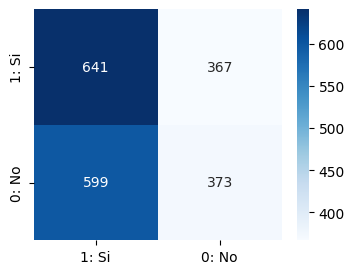

In [8]:
logistica.plot_matriz_confusion("logistic_regression",invertir=True,labels=True,label0="No",label1="Si")

   ### Precisión (Accuracy), Precisión (Precision), exhaustividad (Recall) y F1-Score.

In [ ]:
# llamamos al metodo para obtener los resultaods de las predicciones
df_resultados = logistica.calcular_metricas(modelo_nombre =  "logistic_regression")
df_resultados.head()

,train,test
accuracy,0.551263,0.512121
precision,0.552745,0.510612
recall,0.551263,0.512121
f1,0.544607,0.504239
kappa,0.099775,0.019742
auc,0.570387,0.518392


# Interpretar resultados
### Accuracy
- Un `accuracy` alto significa que el modelo predice correctamente la mayoría de las veces, aunque es importante evaluar si las clases están balanceadas para asegurar que no sea engañoso.
- En nuestro caso ambos valores son bajos, lo que puede sugerir que el modelo no está aprendiendo patrones significativos, especialmente en datos de prueba, donde apenas supera el azar (que sería cercano al 50% si las clases están balanceadas).
### Precision
- Un valor de `precision` alto indica que el modelo tiene pocos falsos positivos.
- En nuestro caso una precisión tan baja sugiere que el modelo genera bastantes falsos positivos, lo que podría ser crítico dependiendo del problema (por ejemplo, en fraudes, se podrían marcar como fraudulentos muchos casos legítimos)
### Recall
- Un `recall` alto significa que el modelo detecta correctamente la mayoría de los casos positivos, lo que es clave cuando es más costoso pasar por alto casos positivos (como en diagnósticos médicos).
- El modelo tiene un rendimiento bajo en términos de recall, lo que indica que se pierden muchos casos positivos.
### F1
- Un valor alto de `F1 Score` indica un equilibrio adecuado entre `precision` y `recall`.
- Los valores bajos del F1 Score refuerzan la idea de que el modelo no es eficaz en general, tanto en precisión como en recall.
### Kappa
- Mide el grado de acuerdo entre las predicciones del modelo y las etiquetas reales, corrigiendo el acuerdo esperado por azar
- Estos valores reflejan un modelo pobremente calibrado, incapaz de encontrar patrones relevantes en los datos.
### AUC
- Evalúa la capacidad del modelo para separar correctamente las clases. Un AUC de 0.5 indica que el modelo no tiene capacidad discriminativa (equivalente a adivinar al azar).
- Este valor confirma que el modelo no está aprendiendo patrones útiles para separar las clases de manera significativa.

### Área bajo la curva ROC (AUC-ROC).

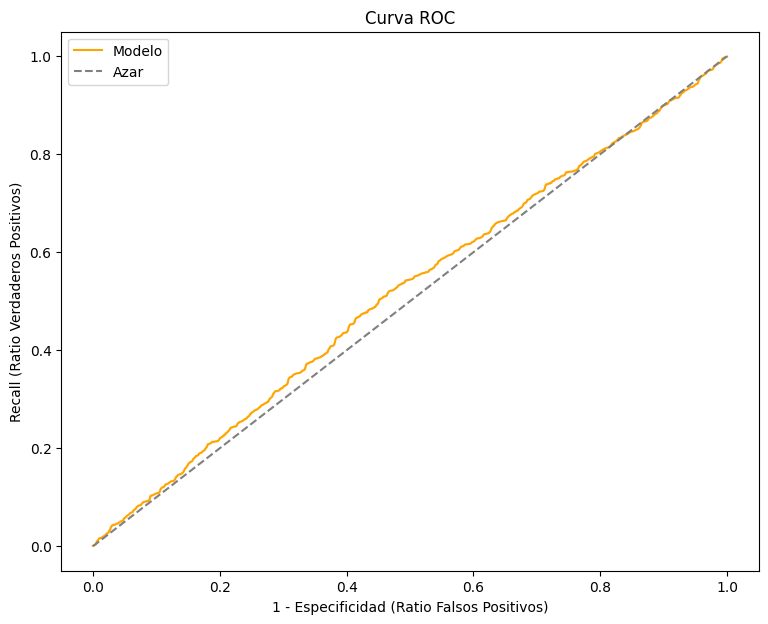

In [7]:
logistica.plot_curva_ROC()

# Parte 3
3. Determinar si el modelo presenta **overfitting** o **underfitting**, analizando el rendimiento en los datos de entrenamiento y prueba.

In [14]:
df_resultados["diferencia"] = df_resultados["train"] - df_resultados["test"]
df_resultados

,train,test,diferencia
accuracy,0.551263,0.512121,0.039141
precision,0.552745,0.510612,0.042134
recall,0.551263,0.512121,0.039141
f1,0.544607,0.504239,0.040368
kappa,0.099775,0.019742,0.080034
auc,0.570387,0.518392,0.051995


Overfitting en este caso no hay, pero las métricas no son buenas